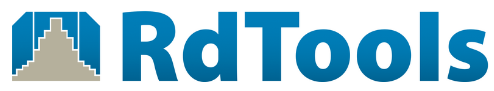

# RdTools: availability

This notebook is for "Part 2: Analytics and Quality Tools" in SETO's [Solar Data Bounty Prize](https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize) webinar series.  It demonstrates a brief example of using PV power plant monitoring data to calculate system availability using [RdTools](https://rdtools.readthedocs.io), an an open-source library to support reproducible technical analysis of time series data.

The power plant under study is [OEDI System 2107](https://openei.org/wiki/PVDAQ/Sites/Farm_Solar_Array), an 893 kW PV system in California, United States.  System 2107 is a ground-mounted fixed-tilt system with 24 inverters.

To run this notebook yourself, you'll need:
- A python environment with `rdtools` and a jupyter notebook interface installed
- The following files downloaded from this system's [OEDI data repository](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=pvdaq%2F2023-solar-data-prize%2F2107_OEDI%2F):
  * `2107_meter_15m_data.csv`
  * `2107_electrical_data.csv`

---

**Other helpful links:**

- RdTools availability documentation: https://rdtools.readthedocs.io/en/stable/generated/rdtools.availability.AvailabilityAnalysis.html
- Another availability analysis code example: https://rdtools.readthedocs.io/en/stable/examples/system_availability_example.html
- [Availability and Performance Loss Factors for U.S. PV Fleet Systems](https://doi.org/10.2172/2318550)
- 2023 Solar Data Bounty Prize: https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize

# Offline, or just communication trouble?

When an inverter trips offline, the system's monitoring data will show zero or perhaps missing values for the inverter's power output.  However, monitoring datasets can contain zero and missing values for other reasons too.  For example, when the communication link between an inverter and the data logger temporarily fails, data for the inverter's production during the communication interruption are usually lost.  To accurately quantify system downtime, "true" outages that affect production must be distinguished from nuisance but ultimately benign communication interruptions.

Let's take a look at some example data to understand one way that RdTools infers whether an inverter was actually offline during a data outage.

In [1]:
import rdtools
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# always good to be aware of what RdTools version is being used
print(rdtools.__version__)

2.1.8


In [3]:
df_meter = pd.read_csv('data/2107_meter_15m_data.csv', index_col=0, parse_dates=True)
df_elect = pd.read_csv('data/2107_electrical_data.csv', index_col=0, parse_dates=True)

In [4]:
# subset the dataframes to just the inverter AC power and meter AC power columns

inv_cols = [x for x in df_elect.columns if 'ac_power' in x]
inverter_powers = df_elect[inv_cols]
# meter data is 15-minute, so resample this 5-minute inverter power to match:
inverter_powers = inverter_powers.resample('15min').mean()

meter_power = df_meter['meter_revenue_grade_ac_output_meter_149578']

Here is an example clear-sky day where all the inverters are producing normally.  The plot on the left shows the individual inverter-level power.  The plot on the right compares two ways of calculating system-level production:
- The AC power recorded at the system meter
- The total (summed) output of the system's inverters

We see that the summed inverter power is slightly higher than the meter power.  This is often the case, due to the small wiring and transformer core losses that occur between the inverter and the meter.

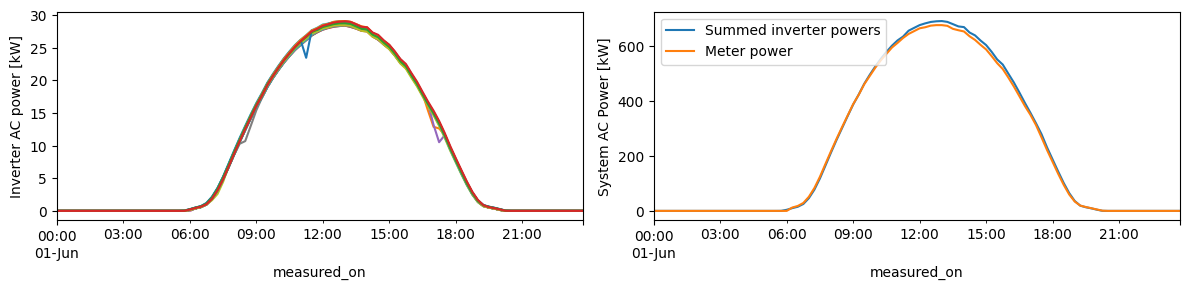

In [5]:
example_day = '2021-06-01'

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
inverter_powers.loc[example_day].plot(ax=axes[0], legend=False, ylabel='Inverter AC power [kW]')

inverter_powers.loc[example_day].sum(axis=1).plot(ax=axes[1], label='Summed inverter powers')
meter_power.loc[example_day].plot(ax=axes[1], label='Meter power', ylabel='System AC Power [kW]')
axes[1].legend()

fig.tight_layout()

Here's another example day, but notice this time that the data contains all zeros for one inverter.  How can we tell if that inverter is actually offline or if it's just a datalogging/communications issue?  Notice in the system-level data (right plot) that this time the summed inverter power is slightly *less* than the meter power.  That means that the meter is recording some extra production beyond what can be seen in the inverter data.  From this, we can infer that the questionable inverter is probably actually online, and the zeros in the inverter data don't reflect an actual production outage.

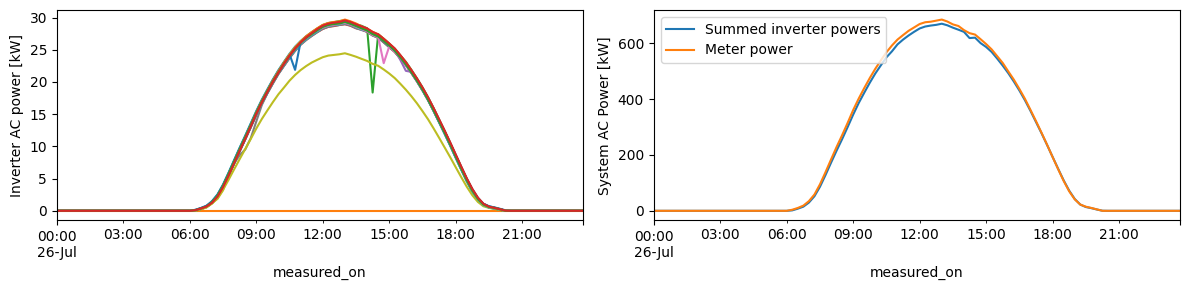

In [6]:
example_day2 = '2019-07-26'

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
inverter_powers.loc[example_day2].plot(ax=axes[0], legend=False, ylabel='Inverter AC power [kW]')

inverter_powers.loc[example_day2].sum(axis=1).plot(ax=axes[1], label='Summed inverter powers')
meter_power.loc[example_day2].plot(ax=axes[1], label='Meter power', ylabel='System AC Power [kW]')
axes[1].legend()

fig.tight_layout()

RdTools performs a quantitative version of this inverter-meter comparison to automatically classify outages and estimate the associated production loss.

# RdTools availability analysis

Now let's see how RdTools analyzes this dataset!

In [7]:
from rdtools.availability import AvailabilityAnalysis

C:\Users\ksande\software\miniconda3\envs\dev\lib\site-packages\rdtools\availability.py:17: UserWarning: The availability module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


Let's focus in on just a few days of data.  As shown above, we need to provide both meter- and inverter-level power data.

In fact, the RdTools availability analysis performs two comparison stages to classify different types of outages.  We are only discussing the first stage here.

In [8]:
power_system = meter_power.loc['2020-02-23': '2020-02-25']
power_subsystem = inverter_powers.loc['2020-02-23': '2020-02-25']

# dummy inputs for stage 2 of the availability analysis
# see RdTools docs for more info
expected_power = power_system
cumulative_energy = power_system.cumsum() / 4

# run the availability analysis with this example dataset:
ava = AvailabilityAnalysis(power_system, power_subsystem, cumulative_energy, expected_power)
ava.run(rollup_period='D')

The main output of the analysis is a table of production statistics and availability fraction:

In [9]:
ava.results

,lost_production,actual_production,availability
2020-02-23,21.521622,2595.999999,0.991778
2020-02-24,575.656063,4157.920000,0.878389
2020-02-25,194.336172,4734.079999,0.960568


We can also take a look at the estimated production loss time series.  Notice that the lost production matches up in time with the outages and reflects both the number of offline inverters and how sunny the conditions were in each timestamp.  These are important aspects of accurate loss calculations.

Text(0, 0.5, 'Estimated power loss [kW]')

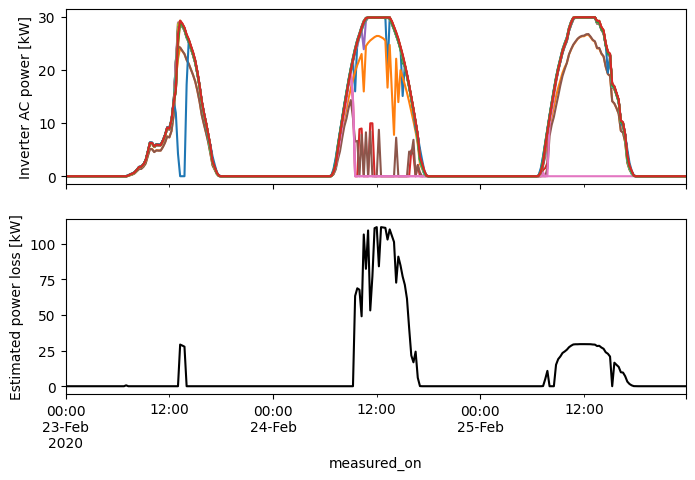

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

power_subsystem.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Inverter AC power [kW]')

ava.loss_subsystem.plot(ax=axes[1], c='k')
axes[1].set_ylabel('Estimated power loss [kW]')